<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import re
import matplotlib.pyplot as plt
from sklearn import preprocessing

from tqdm._tqdm_notebook import tqdm_notebook
from warnings import filterwarnings
import matplotlib.ticker as ticker
%matplotlib inline
filterwarnings('ignore')
# Считываем данные
tr_mcc_codes = pd.read_csv('data/tr_mcc_codes.csv', sep=';', index_col='mcc_code')
tr_types = pd.read_csv('data/tr_types.csv', sep=';', index_col='tr_type')

transactions = pd.read_csv('data/transactions.csv', index_col='customer_id')
gender_train = pd.read_csv('data/gender_train.csv', index_col='customer_id')
gender_test = pd.read_csv('data/gender_test.csv', index_col='customer_id')
transactions_train = transactions.join(gender_train, how='inner')
transactions_test = transactions.join(gender_test, how='inner')

del transactions

tqdm_notebook.pandas(desc="Progress:")

def cv_score(params, train, y_true):
    cv_res=xgb.cv(params, xgb.DMatrix(train, y_true),
                  early_stopping_rounds=10, maximize=True, 
                  num_boost_round=10000, nfold=5, stratified=True)
    index_argmax = cv_res['test-auc-mean'].argmax()
    print('Cross-validation, ROC AUC: {:.3f}+-{:.3f}, Trees: {}'.format(cv_res.loc[index_argmax]['test-auc-mean'],
                                                                        cv_res.loc[index_argmax]['test-auc-std'],
                                                                        index_argmax))

# Построение модели + возврат результатов классификации тестовых пользователей
def fit_predict(params, num_trees, train, test, target):
    params['learning_rate'] = params['eta']
    clf = xgb.train(params, xgb.DMatrix(train.values, target, feature_names=list(train.columns)), 
                    num_boost_round=num_trees, maximize=True)
    y_pred = clf.predict(xgb.DMatrix(test.values, feature_names=list(train.columns)))
    submission = pd.DataFrame(index=test.index, data=y_pred, columns=['probability'])
    return clf, submission

# Отрисовка важности переменных. Важность переменной - количество разбиений выборки, 
# в которых участвует данная переменная. Чем больше - тем она, вероятно, лучше 
def draw_feature_importances(clf, top_k=10):
    plt.figure(figsize=(10, 10))
    
    importances = dict(sorted(clf.get_score().items(), key=lambda x: x[1])[-top_k:])
    y_pos = np.arange(len(importances))
    
    plt.barh(y_pos, list(importances.values()), align='center', color='green')
    plt.yticks(y_pos, importances.keys(), fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel('Feature importance', fontsize=15)
    plt.title('Features importances, Sberbank Gender Prediction', fontsize=18)
    plt.ylim(-0.5, len(importances) - 0.5)
    plt.show()
params = {
    'eta': 0.1,
    'max_depth': 4,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    
    'gamma': 0,
    'lambda': 0,
    'alpha': 0,
    'min_child_weight': 0,
    
    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'tree_method': 'approx'
}

<ipython-input-1-a39faecc7099>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


In [2]:
for df in [transactions_train, transactions_test]:
    df['week_day'] = df['tr_datetime'].str.split().apply(lambda x: int(x[0]) % 7)
    df['day'] = df['tr_datetime'].str.split().apply(lambda x: int(x[0]))
    df['hour'] = df['tr_datetime'].apply(lambda x: re.search(' \d*', x).group(0)).astype(int)
    df['min'] = df['tr_datetime'].str.split().apply(lambda x: int(x[1].split(':')[2]))
    df['night'] = ~df['hour'].between(6, 22).astype(int)

In [13]:
x = transactions_train.merge(tr_mcc_codes, left_on = 'mcc_code', right_on='mcc_code')
x = pd.DataFrame(transactions_train.groupby(['mcc_code','gender'])['amount'].count())
x = x.unstack(-1)
x.columns.droplevel(0)
x['k'] = abs(x[('amount', 0)]-x[('amount', 1)])
x = x.merge(tr_mcc_codes, how='inner',left_index=True, right_index=True)
labels = []
for col in x.columns.values:
    labels.append(str(str(col[0])+'_'+str(col[1])))
x.columns = labels
labels.clear()
x = x.sort_values('k_',ascending=False)
x['k_'] = (x['k_']-x['k_'].min())/(x['k_'].max()-x['k_'].min())
#x = x.reset_index(level=0,drop=True)
x = x[:20]
def mmc_code_top20_feature(x):
    feature = []
    feature.append(pd.Series(x['amount'].value_counts().add_prefix('mcc_feature_')))
    res = pd.concat(feature)
    return res 

y = pd.DataFrame(transactions_train.groupby([transactions_train.index,'mcc_code'])['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('mcc_code_tr_'))
#y = pd.DataFrame(mmc_code_top20_feature(y))
y = y.reset_index().set_index('customer_id')
y = y[y['mcc_code'].isin(x.index.values)]
y = y.set_index([y.index,'mcc_code']).unstack(-1)
labels = []

for col in y.columns.values:
    labels.append(str(str(col[0])+'_'+str(col[1])))
y.columns = labels
labels.clear()
data_train5 = y
del y
y = pd.DataFrame(transactions_test.groupby([transactions_test.index,'mcc_code'])['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('mcc_code_tr_'))
#y = pd.DataFrame(mmc_code_top20_feature(y))
y = y.reset_index().set_index('customer_id')
y = y[y['mcc_code'].isin(x.index.values)]
y = y.set_index([y.index,'mcc_code']).unstack(-1)
labels = []

for col in y.columns.values:
    labels.append(str(str(col[0])+'_'+str(col[1])))
y.columns = labels
labels.clear()

data_test5 = y


In [ ]:
data_train5

In [3]:
def features_creation_advanced(x): 
    features = []
    features.append(pd.Series(x['day'].value_counts().add_prefix('day_')))
    features.append(pd.Series(x['hour'].value_counts().add_prefix('hour_')))
    features.append(pd.Series(x['night'].value_counts().add_prefix('night_')))
    features.append(pd.Series(x['week_day'].value_counts().add_prefix('night_')))
    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('negative_transactions_')))
    
    res = pd.concat(features)
    return res

def features_transaction_per_hour(x):
    features = []
    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['min', 'max', 'mean', 'median', 'std'])\
                                                        .add_prefix('pos_hour_trasaction_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std'])\
                                                        .add_prefix('neg_hour_trasaction_')))
    res = pd.concat(features)
    return res
def features_tr_count_per_day(x):
    features = []
    t = x[x['amount']<0]
    t = t.groupby([t.index,'day'])['amount'].count().unstack(-1)\
                                .add_prefix('day_count_').reset_index().rename_axis(None, axis=1)\
                                .set_index('customer_id')
    #res = pd.concat(features)
    return t

In [4]:
data_train1 = transactions_train.groupby(transactions_train.index)\
                               .progress_apply(features_creation_advanced).unstack(-1)
data_test1 = transactions_test.groupby(transactions_test.index)\
                             .progress_apply(features_creation_advanced).unstack(-1)

Progress::   0%|          | 0/8400 [00:00<?, ?it/s]

Progress::   0%|          | 0/3600 [00:00<?, ?it/s]

In [5]:
data_train2 = transactions_train.groupby([transactions_train.index,'hour'])\
                               .progress_apply(features_transaction_per_hour).unstack(-1)
data_test2 = transactions_test.groupby([transactions_test.index,'hour'])\
                               .progress_apply(features_transaction_per_hour).unstack(-1)
data_train2.reset_index().set_index('customer_id')
data_test2.reset_index().set_index('customer_id')
data_train2 = data_train2.fillna(0)
data_test2 = data_test2.fillna(0)
labels = []

for col in data_train2.columns.values:
    labels.append(str(str(col[0])+'_'+str(col[1])))
data_train2.columns = labels
labels.clear()
for col in data_test2.columns.values:
    labels.append(str(str(col[0])+'_'+str(col[1])))
data_test2.columns = labels

Progress::   0%|          | 0/156543 [00:00<?, ?it/s]

Progress::   0%|          | 0/67060 [00:00<?, ?it/s]

In [6]:
#data_train3 = features_tr_count_per_day(transactions_train)
#data_test3 = features_tr_count_per_day(transactions_test)

In [7]:
def celebration_feature(x):
    features = []
    t = x[(x.amount < 0) & (x.mcc_code.isin([5992,5094,5944,5621,5631]))]
    t = t.groupby([t.index,'day'])['amount'].agg(['min', 'max', 'mean', 'median', 'std']).add_prefix('eight_march_')
    t = t.reset_index().set_index('customer_id')
    t = t[(t.day>=217) & (t.day<=219)]
    t.drop('day', 1)
    return t
    


#eight_march =  transactions_train[(transactions_train.amount < 0) & (transactions_train.mcc_code.isin([5992,5094,5944,5621,5631]))]
#eight_march = eight_march.groupby([eight_march.index,'day'])['amount'].agg(['sum','count']).add_prefix('eight_march_')
#eight_march = eight_march.reset_index().set_index('customer_id')
#eight_march[(eight_march.day>=217) & (eight_march.day<=219)]
data_train4 = celebration_feature(transactions_train)
data_test4 = celebration_feature(transactions_test)
data_test4


,day,eight_march_min,eight_march_max,eight_march_mean,eight_march_median,eight_march_std
customer_id,,,,,,
2173974,219,-21336.20,-3818.06,-12577.130,-12577.130,12387.195588
2649097,219,-24705.07,-24705.07,-24705.070,-24705.070,NaN
3743929,218,-97697.34,-97697.34,-97697.340,-97697.340,NaN
4077097,218,-37955.98,-29107.07,-33531.525,-33531.525,6257.124267
5308727,217,-50533.10,-50533.10,-50533.100,-50533.100,NaN
...,...,...,...,...,...,...
97913958,218,-17068.96,-17068.96,-17068.960,-17068.960,NaN
97913958,219,-3368.87,-3368.87,-3368.870,-3368.870,NaN
98513618,218,-15721.41,-15721.41,-15721.410,-15721.410,NaN


In [28]:
data_test3.index

Int64Index([    6815,    27914,    31385,    38084,    78659,    85327,
              168767,   172390,   186730,   279454,
            ...
            99785861, 99804009, 99836889, 99849278, 99888537, 99918216,
            99938948, 99953525, 99985917, 99991245],
           dtype='int64', name='customer_id', length=3597)

In [ ]:
#data_train1.merge(data_train4, how='left', right_index=True,left_index=True)

In [16]:
data_train = data_train1.merge(data_train2,right_index=True,left_index=True)
data_test = data_test1.merge(data_test2,right_index=True,left_index=True)
#data_train = data_train.merge(data_train3,right_index=True,left_index=True)
#data_test = data_test.merge(data_test3,right_index=True,left_index=True)
data_train = data_train.merge(data_train4,how='left', right_index=True,left_index=True)
data_test = data_test.merge(data_test4,how='left', right_index=True,left_index=True)
data_train = data_train.merge(data_train5,right_index=True,left_index=True)
data_test = data_test.merge(data_test5,right_index=True,left_index=True)

#data_train = data_train4
#data_test = data_test4
#data_train = data_train.fillna(0)
#data_test = data_test.fillna(0)
data_train = (data_train-data_train.mean())/data_train.std()
data_test = (data_test-data_test.mean())/data_test.std()
target = data_train.join(gender_train, how='inner')['gender']
cv_score(params, data_train, target)

Cross-validation, ROC AUC: 0.839+-0.008, Trees: 564


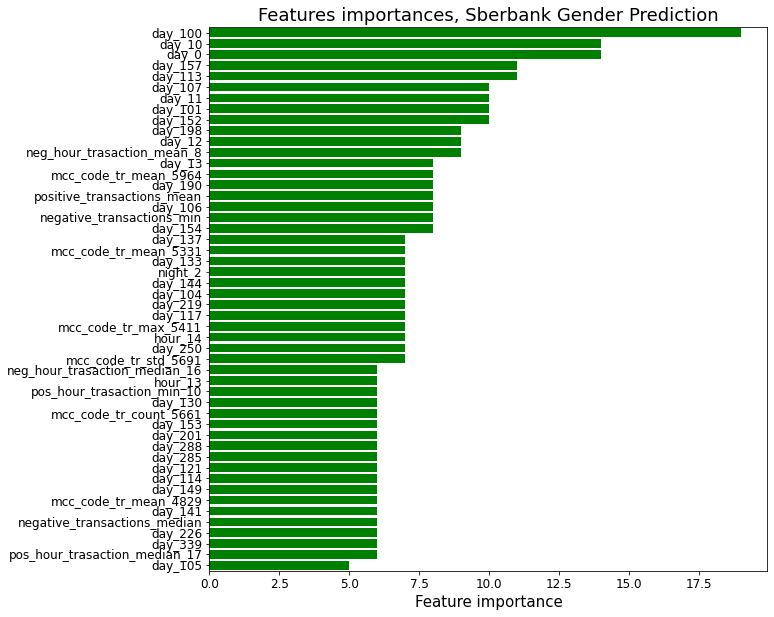

In [17]:
clf, submission = fit_predict(params, 646, data_train, data_test, target)
draw_feature_importances(clf, 50)

In [ ]:
#submission = submission.drop_duplicates(subset=submission.index, keep='first')

In [29]:
submission = submission.reset_index().drop_duplicates(subset='customer_id', keep='first').set_index('customer_id')


In [30]:
submission.index

Int64Index([    6815,    27914,    31385,    38084,    78659,    85327,
               85635,   168767,   172390,   186730,
            ...
            99785861, 99804009, 99836889, 99849278, 99888537, 99918216,
            99938948, 99953525, 99985917, 99991245],
           dtype='int64', name='customer_id', length=3600)

In [32]:
submission.to_csv('../submission_advanced.csv')